In [1]:
# --- Reproducibility: Set random seeds ---
import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

2025-05-09 18:46:15.182799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 18:46:15.190321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746834375.199370  297866 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746834375.202569  297866 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 18:46:15.213459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# --- Configuration ---
CONFIG = {
    "data_path": "data/emnist_balanced.npz",
    "mapping_file": "emnist-balanced-mapping.txt",
    "model_checkpoint": "savedModels/CNN-Model.keras",
    "batch_size": 64,
    "epochs": 20,
    "input_shape": (28, 28, 1),
    "num_classes": 47,
    "test_path": "path/to/your/image.png",  # Update this path for inference
}


# CNN Training Notebook
This notebook trains the EMNIST Balanced model with a deeper architecture, no augmentation to ensure proper learning, and robust callbacks.

In [3]:
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras import layers, models, optimizers, callbacks

# Reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
# Ensures determinism on GPU (helps debugging)
tf.config.experimental.enable_op_determinism()


In [4]:
# Load and preprocess EMNIST data
data = np.load('data/emnist_balanced.npz')
x = data['x']
y = data['y']

# Correct orientation: rotate and flip
x = np.transpose(x, (0, 2, 1))
x = np.flip(x, axis=2)

# Normalize and add channel dimension
x = x.astype('float32') / 255.0
x = x[..., np.newaxis]

print(f"Data shapes before split: {x.shape}, {y.shape}")


Data shapes before split: (112800, 28, 28, 1), (112800,)


In [5]:
# ----------------------------------------------------------
# Stratified Train / Validation / Test split
# 10% of full data -> test, 10% of remaining -> validation
# ----------------------------------------------------------
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, test_idx = next(sss.split(x, y))
x_train_full, x_test = x[train_idx], x[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, val_idx = next(sss2.split(x_train_full, y_train_full))
x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (91368, 28, 28, 1), Val: (10152, 28, 28, 1), Test: (11280, 28, 28, 1)


In [6]:
# ----------------------------------------------------------
# Corrected Train/Val/Test split (stratified)
#  - 10% of the full dataset for the final test set
#  - 10% of the remaining data for validation
# ----------------------------------------------------------
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, test_idx = next(sss.split(x, y))
x_train_full, x_test = x[train_idx], x[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, val_idx = next(sss_val.split(x_train_full, y_train_full))
x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (91368, 28, 28, 1), Val: (10152, 28, 28, 1), Test: (11280, 28, 28, 1)


In [7]:
# Model architecture
model = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(47, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)
model.summary()

I0000 00:00:1746834378.419146  297866 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,839 (1.53 MB)

 Trainable params: 400,879 (1.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
# Callbacks: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint_path = 'savedModels/CNN-Model-v2.keras'
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

import os
os.makedirs('savedModels', exist_ok=True)

In [9]:
# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=cb,
    verbose=2
)

Epoch 1/25


2025-05-09 18:46:19.343180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1746834380.509460  297969 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-05-09 18:46:27.389282: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:var

1428/1428 - 9s - 6ms/step - accuracy: 0.7250 - loss: 0.9654 - sparse_top_k_categorical_accuracy: 0.9045 - val_accuracy: 0.0970 - val_loss: 12.5785 - val_sparse_top_k_categorical_accuracy: 0.1505 - learning_rate: 3.0000e-04
Epoch 2/25
1428/1428 - 6s - 4ms/step - accuracy: 0.8369 - loss: 0.4962 - sparse_top_k_categorical_accuracy: 0.9742 - val_accuracy: 0.0286 - val_loss: 11.3186 - val_sparse_top_k_categorical_accuracy: 0.0835 - learning_rate: 3.0000e-04
Epoch 3/25
1428/1428 - 6s - 4ms/step - accuracy: 0.8574 - loss: 0.4176 - sparse_top_k_categorical_accuracy: 0.9817 - val_accuracy: 0.0427 - val_loss: 13.3418 - val_sparse_top_k_categorical_accuracy: 0.0739 - learning_rate: 3.0000e-04
Epoch 4/25
1428/1428 - 6s - 4ms/step - accuracy: 0.8704 - loss: 0.3737 - sparse_top_k_categorical_accuracy: 0.9854 - val_accuracy: 0.0404 - val_loss: 14.6787 - val_sparse_top_k_categorical_accuracy: 0.1012 - learning_rate: 3.0000e-04
Epoch 5/25
1428/1428 - 6s - 4ms/step - accuracy: 0.8783 - loss: 0.3439 - sp

In [10]:
results = model.evaluate(x_test, y_test, verbose=2, return_dict=True)
print(f"Loss: {results['loss']:.4f}")
print(f"Top‑1 Accuracy: {results['accuracy']:.4f}")
print(f"Top‑3 Accuracy: {results['sparse_top_k_categorical_accuracy']:.4f}")


2025-05-09 18:48:49.578688: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


353/353 - 1s - 1ms/step - accuracy: 0.8855 - loss: 0.3271 - sparse_top_k_categorical_accuracy: 0.9905
Loss: 0.3271
Top‑1 Accuracy: 0.8855
Top‑3 Accuracy: 0.9905


In [11]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       240
           1       0.57      0.67      0.61       240
           2       0.93      0.87      0.90       240
           3       0.99      0.98      0.99       240
           4       0.93      0.93      0.93       240
           5       0.90      0.97      0.93       240
           6       0.96      0.90      0.93       240
           7       0.97      0.99      0.98       240
           8       0.98      0.92      0.95       240
           9       0.68      0.80      0.74       240
          10       0.99      0.95      0.97       240
          11       0.93      0.98      0.95       240
          12       0.98      0.95      0.97       240
          13       0.90      0.97      0.93       240
          14       0.99      0.99      0.99       240
          15       0.68      0.65      0.66       240
          16       0.94      0.93      0.93       240
          17       0.94    

In [12]:
mapping = {}
with open('emnist-balanced-mapping.txt', 'r') as f:
    for line in f:
        if not line.strip():  # skip empty lines
            continue
        parts = line.strip().split()
        if len(parts) != 2:
            print(f"Skipping malformed line: {line.strip()}")
            continue
        idx, ascii_code = map(int, parts)
        mapping[idx] = chr(ascii_code)

print(f"Loaded {len(mapping)} classes. Example: 0 → {mapping[0]}")


Loaded 47 classes. Example: 0 → 0


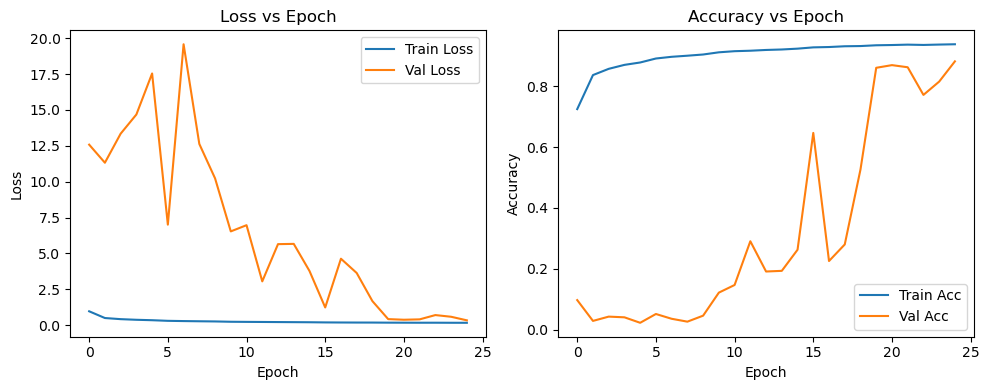

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


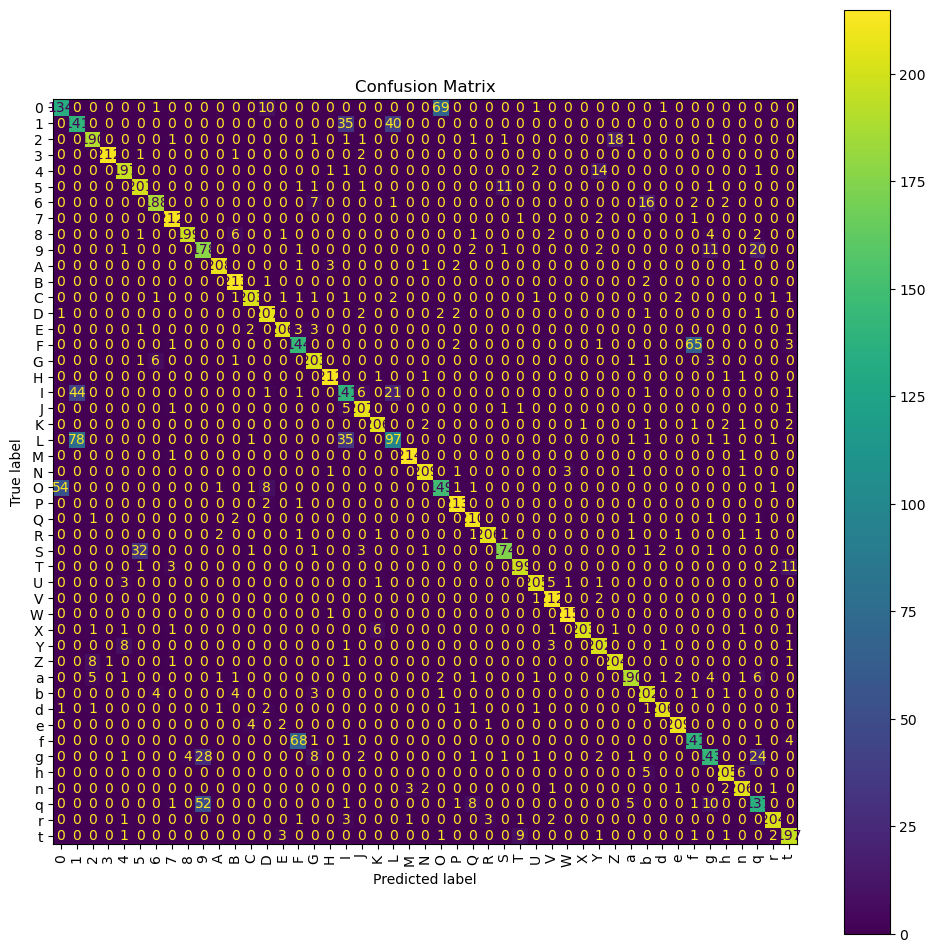

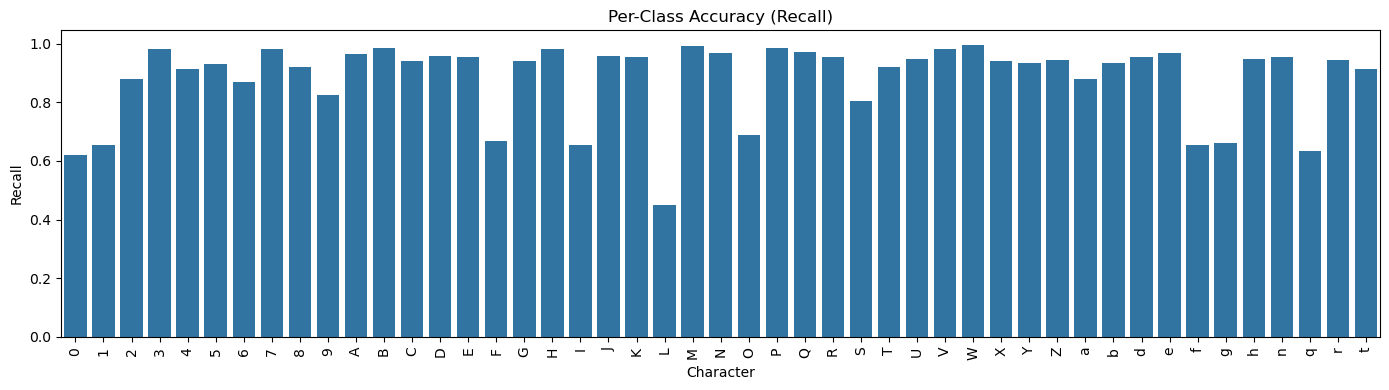

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


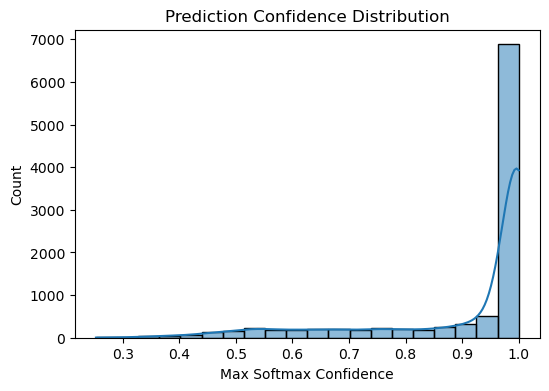

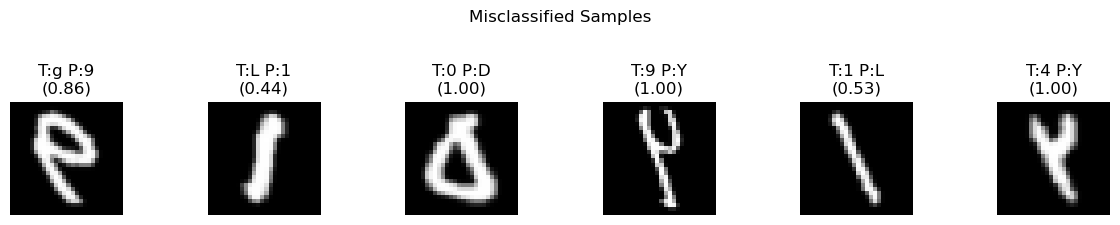

Top-3 Accuracy: 0.9898


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# === 1. Plot Training Loss and Accuracy ===
plt.figure(figsize=(10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# === 2. Confusion Matrix ===
y_pred = model.predict(x_val).argmax(axis=1)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[mapping[i] for i in sorted(mapping)])
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


# === 3. Per-Class Accuracy (Recall) ===
report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
per_class_recall = {mapping[int(k)]: v['recall'] for k, v in report.items() if k.isdigit()}

plt.figure(figsize=(14, 4))
sns.barplot(x=list(per_class_recall.keys()), y=list(per_class_recall.values()))
plt.xticks(rotation=90)
plt.title("Per-Class Accuracy (Recall)")
plt.ylabel("Recall")
plt.xlabel("Character")
plt.tight_layout()
plt.show()


# === 4. Confidence Histogram ===
y_probs = model.predict(x_val)
max_confidences = y_probs.max(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(max_confidences, bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Softmax Confidence")
plt.ylabel("Count")
plt.show()


# === 5. Misclassified Samples ===
wrong_idxs = np.where(y_pred != y_val)[0]
n = 6
sampled = np.random.choice(wrong_idxs, n)

plt.figure(figsize=(12, 2))
for i, idx in enumerate(sampled):
    img = x_val[idx].squeeze()
    true_lbl = mapping[y_val[idx]]
    pred_lbl = mapping[y_pred[idx]]
    conf = y_probs[idx][y_pred[idx]]

    plt.subplot(1, n, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{true_lbl} P:{pred_lbl}\n({conf:.2f})")
    plt.axis('off')
plt.suptitle("Misclassified Samples", y=1.1)
plt.tight_layout()
plt.show()


# === 6. Top-K Accuracy (Optional) ===
top_k = 3
top_k_correct = np.any(np.argsort(y_probs, axis=1)[:, -top_k:] == y_val[:, None], axis=1)
top_k_acc = np.mean(top_k_correct)
print(f"Top-{top_k} Accuracy: {top_k_acc:.4f}")


In [14]:
# Load raw data
data = np.load('data/emnist_balanced.npz')
x_raw = data['x']           # Original uint8 images
y = data['y']

# Preprocess x (rotate, flip, normalize, add channel)
x = np.transpose(x_raw, (0, 2, 1))
x = np.flip(x, axis=2)
x = x.astype('float32') / 255.0
x = x[..., np.newaxis]

# Split both x and x_raw so we can pair originals with processed
from sklearn.model_selection import train_test_split

x_train, x_temp, x_raw_train, x_raw_temp, y_train, y_temp = train_test_split(
    x, x_raw, y, test_size=0.3, random_state=42, stratify=y
)

x_val, x_test, x_raw_val, x_raw_test, y_val, y_test = train_test_split(
    x_temp, x_raw_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


[1] True Index: 6 → '6'
    Input min/max: 0.00/0.00
    Predicted Index: 6 → '6' with confidence 1.00
    Top 3 predictions: [('6', np.float32(0.9999672)), ('G', np.float32(2.0100166e-05)), ('b', np.float32(1.0713179e-05))]


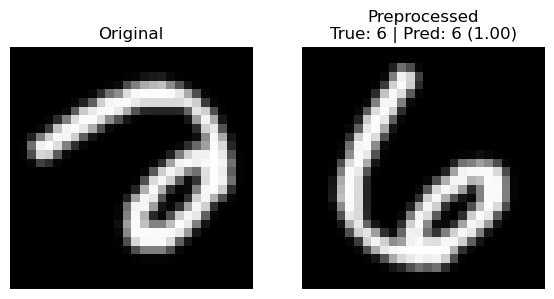

[2] True Index: 0 → '0'
    Input min/max: 0.00/0.00
    Predicted Index: 0 → '0' with confidence 0.79
    Top 3 predictions: [('0', np.float32(0.7850223)), ('O', np.float32(0.20807232)), ('D', np.float32(0.0056347307))]


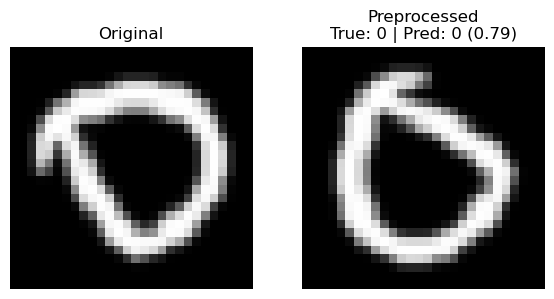

[3] True Index: 11 → 'B'
    Input min/max: 0.00/0.00
    Predicted Index: 11 → 'B' with confidence 1.00
    Top 3 predictions: [('B', np.float32(0.99899083)), ('P', np.float32(0.0008252694)), ('Q', np.float32(6.0050184e-05))]


2025-05-09 18:48:54.968816: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


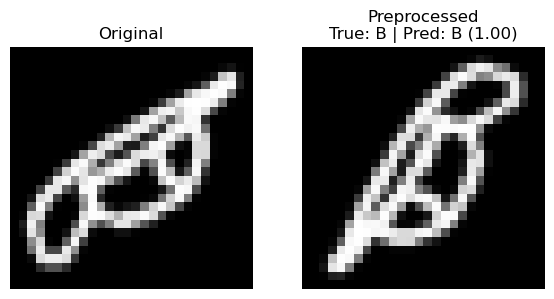

[4] True Index: 31 → 'V'
    Input min/max: 0.00/0.00
    Predicted Index: 31 → 'V' with confidence 0.92
    Top 3 predictions: [('V', np.float32(0.91745657)), ('Y', np.float32(0.07543668)), ('U', np.float32(0.0056962315))]


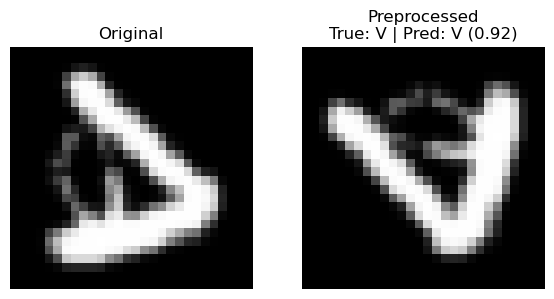

[5] True Index: 19 → 'J'
    Input min/max: 0.00/0.00
    Predicted Index: 19 → 'J' with confidence 1.00
    Top 3 predictions: [('J', np.float32(0.999938)), ('I', np.float32(1.8015016e-05)), ('G', np.float32(1.6019052e-05))]


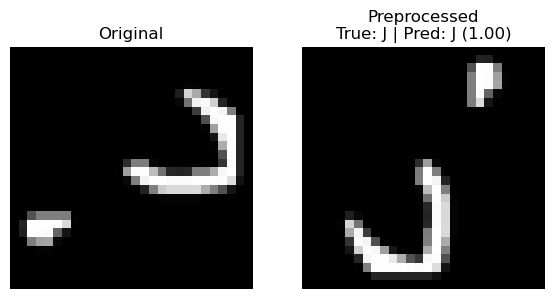

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Number of examples to plot
n = 5

# Pick n random indices from validation set
idxs = np.random.choice(len(x_val), size=n, replace=False)

for i, idx in enumerate(idxs):
    # Retrieve original and preprocessed images (correctly aligned)
    orig_img = x_raw_val[idx]             # original (uint8, unrotated)
    proc_img = x_val[idx].squeeze()       # preprocessed (rotated + flipped + normalized)

    # Undo flip *only for display*
    proc_img_display = np.flip(proc_img, axis=1)

    # True label
    true_idx = y_val[idx]
    true_lbl = mapping[true_idx]

    # Model prediction (on real preprocessed input)
    inp = proc_img.reshape(1, 28, 28, 1)
    preds = model.predict(inp, verbose=0)[0]
    pred_idx = preds.argmax()
    pred_lbl = mapping[pred_idx]
    pred_conf = preds[pred_idx]

    # Debug output
    print(f"[{i+1}] True Index: {true_idx} → '{true_lbl}'")
    print(f"    Input min/max: {proc_img.min():.2f}/{proc_img.max():.2f}")
    print(f"    Predicted Index: {pred_idx} → '{pred_lbl}' with confidence {pred_conf:.2f}")
    top3_idx = preds.argsort()[-3:][::-1]
    top3 = [(mapping[i], preds[i]) for i in top3_idx]
    print("    Top 3 predictions:", top3)

    # Plot original and corrected preprocessed image (unflipped for viewing)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(orig_img, cmap='gray')
    ax1.set_title("Original")
    ax1.axis('off')

    ax2.imshow(proc_img_display, cmap='gray')
    ax2.set_title(f"Preprocessed\nTrue: {true_lbl} | Pred: {pred_lbl} ({pred_conf:.2f})")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
